# Dependencies
We need to install tensorflow 2.7.0 to be compatible with quantum tensorflow

In [1]:
#!pip install -q tensorflow==2.7.0

#!pip install -q tensorflow-quantum

In [2]:
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
import sympy
import numpy as np
from collections import deque
from random import sample
from functools import reduce
import sys

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit


2022-11-30 13:51:34.257509: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-30 13:51:34.257559: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-30 13:51:42.224704: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-30 13:51:42.224740: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-30 13:51:42.224763: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (marshalls-VB): /proc/driver/nvidia/version does not exist
2022-11-30 13:51:42.225171: I tensorflow/core/platform/cpu_featu

This array specifies hyper-parameters of the training run.
For the paper these are set in the command line, but for this notebook we hard code them to some demonstration values.

In [3]:
#L,k, number of epochs of training, number of training data
L = 1
k = 8#changing this will not change the training run, yet!
epochs = 100 #changing this will not change the training run, yet!
n_training = 100 #changing this will not change the training run, yet!
random_seed = 69 #changing this will not change the training run, yet!

data_augmentation = 100 # repititions of the data set
numb_of_repeats = 1 # number of times the training is repeated, used to average with a new random init


arguments_passed= [L, epochs, numb_of_repeats]

# Define model

This section will define the partitioned model that we will use.

The first 3 cells define "circuit generation", generating the ansatz we will use

## circuit generation

We will borrow heavily from the code of Sofiene and Andrea

We define a circuit by specifying the number of layers it needs to have, adding a controlled X on the first qubit, and a controlled Z on the last qubit, for every layer

In [4]:
def one_qubit_rotation(qubit, symbols):
    """
    Returns a Cirq circuit that applies a rotation of the bloch sphere about the X,
    Y and Z axis, specified by the values in `symbols`.
    """
    yield cirq.rx(symbols[0])(qubit)
    yield cirq.ry(symbols[1])(qubit)
    yield cirq.rz(symbols[2])(qubit)

def entangling_layer(qubits, part_of_hadamard_test=True):
    """
    Returns a Cirq circuit that applies a layer of entangling gates (arranged in a circular topology).
    """
    if len(qubits) == 2:
        yield cirq.Circuit(cirq.CZ(qubits[0], qubits[1]))
    else:
        yield cirq.Circuit(cirq.CZ(qubits[i], qubits[(i + 1) % len(qubits)]) for i in range(len(qubits)))

def Cone_qubit_rotation(control, qubit, symbols):
    """
    Returns a Cirq circuit that applies a ortation of the bloch sphere about the X,
    Y and Z axis, specified by the values in `symbols`. 

    We now use a controlled rotation, where the control qubit is the first qubit in the circuit. This is useful for the hadamard test.
    """
    yield cirq.rx(symbols[0])(qubit).controlled_by(control)
    yield cirq.ry(symbols[1])(qubit).controlled_by(control)
    yield cirq.rz(symbols[2])(qubit).controlled_by(control)

The following function creates the full circuit with a control on the first qubit

In [5]:
def gen_cont_circ(qubits,n_layers, real=True):
  """gens a controlled circuit, but half is controlled by the last qubit to replicate off diag terms"""
  #circuit width
  n = len(qubits) - 1
  control_qubit = qubits[n] #last qubit is the control
  #generate weight set, 2x normal because double depth
  params = sympy.symbols(f'theta(0:{3*(n_layers+1)*n})')
  params = np.asarray(params).reshape(((n_layers + 1), n, 3))

  bravyi_params = sympy.symbols(f'zeta(0:{2*2*(n_layers)})')
  bravyi_params = np.asarray(bravyi_params).reshape((2*n_layers, 2))

  # Sympy symbols for encoding angles
  inputs = sympy.symbols(f'x(0:{n})'+f'_(0:{n_layers})')
  inputs = np.asarray(inputs).reshape((n_layers, n))

  #apply first H
  circuit=cirq.Circuit(cirq.H(control_qubit))
  if not real: circuit+= cirq.S(control_qubit)

  #make controlled circuit 1:
  #circuit = cirq.Circuit()
  for l in range(n_layers):
    # Variational layer
    circuit += cirq.Circuit(one_qubit_rotation(q, params[l, i]) for i, q in enumerate(qubits[:-1]))
    circuit += entangling_layer(qubits[:-1])
    #bravyi ghost encoding things
    circuit += cirq.ZPowGate(exponent = bravyi_params[l, 0], global_shift=0)(qubits[0  ]).controlled_by(control_qubit) #the x or target qubit (on the first qubit)
    circuit += cirq.ZPowGate(exponent = bravyi_params[l, 1], global_shift=0)(qubits[n-1]).controlled_by(control_qubit)#The z or control qubit (goes on the last qubit)
    #need to swap which circuit we're applying (apply the 1 circuit)
    circuit+=cirq.Circuit(cirq.X(control_qubit))
    #other bravyi ghost encoding things
    circuit += cirq.ZPowGate(exponent = bravyi_params[l+n_layers, 0], global_shift=0)(qubits[ 0 ]).controlled_by(control_qubit)#The x or target qubit (on the first qubit)
    circuit += cirq.ZPowGate(exponent = bravyi_params[l+n_layers, 1], global_shift=0)(qubits[n-1]).controlled_by(control_qubit)#The z or control qubit (goes on the last qubit)
    #need to swap back
    circuit+=cirq.Circuit(cirq.X(control_qubit))

    # Encoding layer
    circuit += cirq.Circuit(cirq.rx(inputs[l, i])(q) for i, q in enumerate(qubits[:-1]))

  circuit += cirq.Circuit(one_qubit_rotation(q, params[n_layers, i]) for i,q in enumerate(qubits[:-1]))


  #reinvert and apply 2nd H gate
  #circuit+=cirq.Circuit(cirq.X(control_qubit))
  circuit+=cirq.Circuit(cirq.H(control_qubit))
  if not real: circuit+= cirq.S(control_qubit)
  return circuit, list(bravyi_params.flat),list(params.flat), list(inputs.flat)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


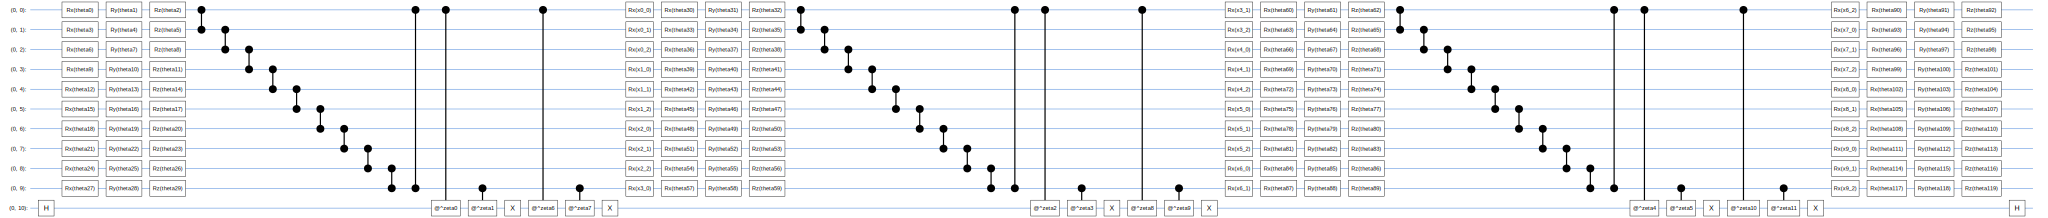

In [6]:
#test circuit
n_qubits, n_layers = 11, 3
qubits = cirq.GridQubit.rect(1, n_qubits)
circuit, bp, tp, ip = gen_cont_circ(qubits, n_layers, real = True)
SVGCircuit(circuit)

## Convert to a tensorflow model
taking the circuits generators from the previous model we can stitch the models together in a custom keras model.


In [7]:
class gen_comb_model(tf.keras.Model):
  """Generates the shit out of a model"""
  def __init__(self, n, d, K, L, input_dim = 5):
    """initalise, n is number of qubits in each PQC, d is the depth of the PQC
    K is the number of terms in the product, L is the number of terms in the sum"""
    super().__init__()
    self.n = n
    self.d = d
    self.K = K
    self.L = L
    self.size_of_split=n

    # qubits, observable, define circuit
    qubits = cirq.GridQubit.rect(1, self.n+1)
    ops = [cirq.Z(q) for q in qubits]
    observables = [reduce((lambda x, y: x * y), ops)] # Z_0*Z_1*Z_2*Z_3
    #define circuit and imaginary circuit,
    circuit, bravyi_params, theta_symbols, input_symbols  = gen_cont_circ(qubits, d)
    circuiti, _,              _,              _            = gen_cont_circ(qubits, d, real=False)
    #print(circuit)

    # define PQC weights and that shit
    #regular weights, the thetas
    theta_init = tf.random_uniform_initializer(minval=0.0, maxval=np.pi)
    self.theta = tf.Variable(
        initial_value=theta_init(shape=(1, len(theta_symbols)*K), dtype="float32"),
        trainable=True, name="thetas")
    self.individual_product_term_theta_size = len(theta_symbols)

    #weights to multiply by the training data, previously called lmbd in a move that wont be ridiculously confusing here.
    alphas_init = tf.ones(shape=(len(input_symbols)*K,))
    self.alphas = tf.Variable(
        initial_value=alphas_init, dtype="float32", trainable=True, name="alphas"
    )
    self.input_dim = len(input_symbols)*K

    #other shit
    self.activation = "linear"
    self.empty_circuit = tfq.convert_to_tensor([cirq.Circuit()])
    self.computation_layer = tfq.layers.ControlledPQC(circuit, observables)
    self.imag_computation_layer = tfq.layers.ControlledPQC(circuiti, observables)
    self.flatten = tf.keras.layers.Flatten(input_shape=(input_dim,input_dim))

    # define explicit order for symbols
    symbols = [str(symb) for symb in theta_symbols+input_symbols+bravyi_params ]
    self.indices = tf.constant([symbols.index(a) for a in sorted(symbols)])
    
    # define zeta parameters
    zeta_init = tf.random_uniform_initializer(minval=0.0, maxval=np.pi)
    self.zeta = tf.Variable(
        initial_value=zeta_init(shape=(L,K, len(bravyi_params)), dtype="float32"),
        trainable=True, name="zetas")
    
    # define lambdas
    rescale_parameter=1 #may need modifying later (lol)
    lambdas_init = tf.ones(shape=(L,))*rescale_parameter
    self.lambdas = tf.Variable(initial_value=lambdas_init, dtype="float32", trainable=True, name="lambdas")

  def giveZetas(self):
    return self.zeta

  def giveIndices(self):
    return self.indices

  def normalise_lambdas(self, inputs):
    """the outputs of the products are much much smaller than the lambdas that 
    multiply them this means the output of the whole ciruit is so fucking tiny.
    To remedy this, this function will take a set of inputs, and then set lambdas
    to 1/L x {the average magnitude of the inputs}
    """
    #A huge amount is copied directly from the call function
    #gather amount of data points
    batch_dim = tf.gather(tf.shape(inputs[0]), 0)
    #copy thetas and inputs for inputs
    tiled_up_thetas = tf.tile(self.theta, multiples=[batch_dim, 1])
    inputs = [self.flatten(inputs[0])]
    tiled_up_inputs = tf.tile(inputs[0], multiples=[1, self.d])#need double the amount of input copies
    scaled_inputs = tf.einsum("i,ji->ji", self.alphas, tiled_up_inputs)# This needs to be worked in, we should apply alphas before dividing it
    squashed_inputs = tf.keras.layers.Activation(self.activation)(tiled_up_inputs)
    
    for j in range(self.L):
      PQC_layer_ans = tf.complex(tf.ones([batch_dim, 1]),tf.zeros([batch_dim, 1]))#the complex number for the product part of the calculation
      for i in range(self.K):
        #rack up some circuits to use in the PQC
        tiled_up_circuits = tf.repeat(self.empty_circuit, repeats=batch_dim)
        tiled_up_circuitsi= tf.repeat(self.empty_circuit, repeats=batch_dim) 

        #take the inputs for this circuit
        our_inputs =tf.slice(squashed_inputs, [0,i*self.n], [batch_dim, self.n*self.d])
        ####################################################################################################################################################HERE YOU MIGHT WANT TO CHANGE THE WAY WE PICK INPUTS, ITS IMPORTANT WE dont try and select parts of the input vector that dont exist
        
        # take the thetas we want
        our_thetas = tf.slice(tiled_up_thetas, [0,i*self.individual_product_term_theta_size], [batch_dim, self.individual_product_term_theta_size])
        
        #add in zetas
        our_zeta = tf.slice(self.zeta, [j,i,0], [1,1,-1])
        tileup_our_zeta = tf.reshape(our_zeta, our_zeta.shape[1:])
        tiled_zeta = tf.tile(tileup_our_zeta, multiples = [batch_dim, 1])
        # put it all together
        joined_vars = tf.concat([our_thetas, our_inputs, tiled_zeta], axis=1)
        #print("b4", joined_vars)
        joined_vars = tf.gather(joined_vars, self.indices, axis=1)
        #print("A", joined_vars)
        computation = tf.complex(self.computation_layer([tiled_up_circuits, joined_vars]),self.imag_computation_layer([tiled_up_circuitsi, joined_vars]))
        
        PQC_layer_ans = tf.math.multiply(computation, PQC_layer_ans)
          
      PQC_layer_ans = tf.math.real(PQC_layer_ans)
      abs_recipricol_PQC_layer_ans = tf.math.abs(tf.math.reciprocal(PQC_layer_ans))
      lambda_rescaling = tf.math.reduce_sum(abs_recipricol_PQC_layer_ans)  /   (L*batch_dim.numpy())
      self.lambdas[j].assign(23.)#lambda_rescaling)
      print(lambda_rescaling)

  def call(self, inputs):
    #lets keep it simple in this run, copy the circuit outputs for each different parameters, ew can put through multiple parameters at another time.
    #gather amount of data points
    batch_dim = tf.gather(tf.shape(inputs[0]), 0)
    #copy thetas and inputs for inputs
    tiled_up_thetas = tf.tile(self.theta, multiples=[batch_dim, 1])
    inputs = [self.flatten(inputs[0])]
    tiled_up_inputs = tf.tile(inputs[0], multiples=[1, self.d])#need double the amount of input copies
    scaled_inputs = tf.einsum("i,ji->ji", self.alphas, tiled_up_inputs)# This needs to be worked in, we should apply alphas before dividing it
    squashed_inputs = tf.keras.layers.Activation(self.activation)(tiled_up_inputs)
    
    #hold hte circuit outputs for each input
    ans = tf.zeros([batch_dim, 1])
    for j in range(self.L):
      PQC_layer_ans = tf.complex(tf.ones([batch_dim, 1]),tf.zeros([batch_dim, 1]))#the complex number for the product part of the calculation
      for i in range(self.K):
        #rack up some circuits to use in the PQC
        tiled_up_circuits = tf.repeat(self.empty_circuit, repeats=batch_dim)
        tiled_up_circuitsi= tf.repeat(self.empty_circuit, repeats=batch_dim) 

        #take the inputs for this circuit
        our_inputs =tf.slice(squashed_inputs, [0,i*self.n], [batch_dim, self.n*self.d])
        ####################################################################################################################################################HERE YOU MIGHT WANT TO CHANGE THE WAY WE PICK INPUTS, ITS IMPORTANT WE dont try and select parts of the input vector that dont exist
        
        # take the thetas we want
        our_thetas = tf.slice(tiled_up_thetas, [0,i*self.individual_product_term_theta_size], [batch_dim, self.individual_product_term_theta_size])
        
        #add in zetas
        our_zeta = tf.slice(self.zeta, [j,i,0], [1,1,-1])
        tileup_our_zeta = tf.reshape(our_zeta, our_zeta.shape[1:])
        tiled_zeta = tf.tile(tileup_our_zeta, multiples = [batch_dim, 1])
        # put it all together
        joined_vars = tf.concat([our_thetas, our_inputs, tiled_zeta], axis=1)
        #print("b4", joined_vars)
        joined_vars = tf.gather(joined_vars, self.indices, axis=1)
        #print("A", joined_vars)
        computation = tf.complex(self.computation_layer([tiled_up_circuits, joined_vars]),self.imag_computation_layer([tiled_up_circuitsi, joined_vars]))
        
        PQC_layer_ans = tf.math.multiply(computation, PQC_layer_ans)
      lambdas = tf.math.exp(self.lambdas[j])
      PQC_layer_ans = tf.math.real(PQC_layer_ans) #when adding, all imag terms will cancel anyway
      ans = tf.math.add(lambdas*PQC_layer_ans, ans) # multiply the product by the weight lambda and throw it on the pile
    return ans


# Get data

In [8]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


In [9]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)
print(x_train.shape)
print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

(12049, 28, 28, 1)
Number of filtered training examples: 12049
Number of filtered test examples: 1968


Often the number of data sets we get just isnt enough for the amount of training we have to do, so lets augment our training set with some data that we create by adding a shear function.

In [10]:
augment_data_sets =  int(arguments_passed[1]*0.4)#how many multiples of the data set should we create, should be 0.4*number of epochs
data_set_size = len(x_train)

play_ds = x_train[0:data_set_size,:,:,0]
reshaped_ds = play_ds.reshape((data_set_size,28,28,1))
y_train_ds = y_train[0:data_set_size]
play_ds = np.copy(reshaped_ds)
play_y = np.copy(y_train_ds)
print(play_ds.shape, reshaped_ds.shape)

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=0, shear_range=30.0, zoom_range=0.10)
datagen.fit(reshaped_ds)


for i in range(augment_data_sets):
  dgflow = datagen.flow(reshaped_ds, y_train_ds, batch_size=data_set_size)
  newData = next(dgflow)
  x_ds, y_ds =newData
  #x_ds = x_ds.reshape(data_set_size, 28, 28)
  play_ds = np.concatenate((play_ds,x_ds))
  play_y = np.concatenate((play_y,y_ds))

print(play_ds.shape)

y_train = play_y
x_train=play_ds

(12049, 28, 28, 1) (12049, 28, 28, 1)
(60245, 28, 28, 1)


Downscale the data to fit on our machine

True


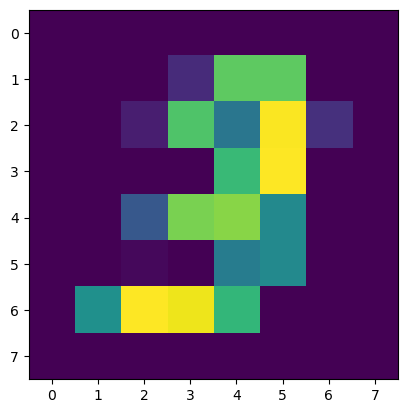

True


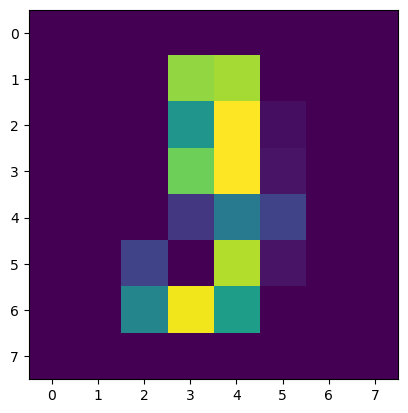

True


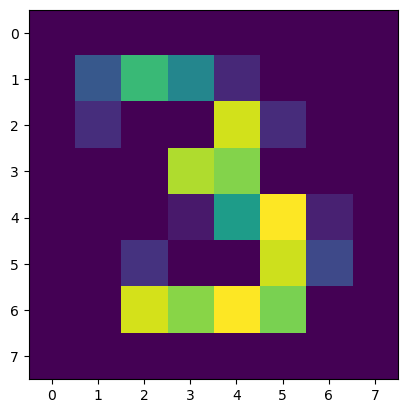

False


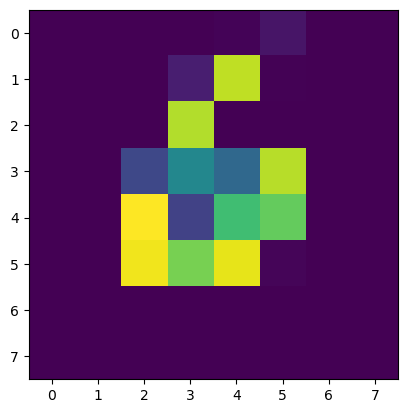

False


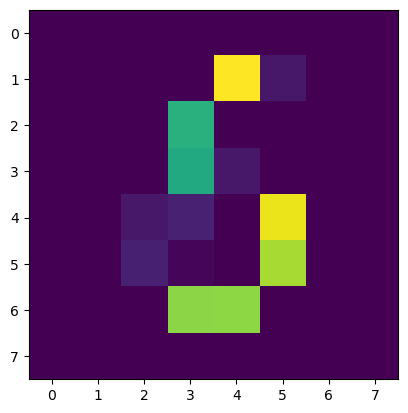

In [11]:
rescale_to = 8
x_train_small = tf.image.resize(x_train, (rescale_to,rescale_to)).numpy()
x_test_small = tf.image.resize(x_test, (rescale_to,rescale_to)).numpy()
for i in range(5):
  plt.imshow(x_train_small[i,:,:,0])
  print(y_train[i])
  plt.show()

# Fit
With our model and date collected we can simply fit this with keras.fit
 

## Pretraining prep
Tweak the data to be in a quantum-friendly format
Also a function to let us play with the data in a clearer form

In [12]:
y_data= np.array([[int(y_train[i])] for i in range(len(y_train))])
x_data=[np.array([x_train_small[i] for i in range(len(x_train_small))])]


x_test2 = [np.array([x_test_small[i] for i in range (300)])]
peak_set= [np.array([x_test_small[i] for i in range (1)])]

#and an absololute test function
def model_tester(model, verbose=True, ):
  labels = model(x_test2)
  right = 0
  wrong = 0
  for i, val in enumerate(labels):
    val = val.numpy()[0]
    if (val-y_test[i])**2<0.25:
      right+=1
    else: wrong+=1
  if verbose:
    print("In the testing set:")
    print(right, " points classified correctly\n", wrong, " points classified incorrectly")
    print("for a classification accuracy of ", round(right/(wrong+right)*100, 2), "%")




## and Train

In [13]:
n,d,K,L = 8, 3, 8, arguments_passed[0]
print("n,d,K,L", n,d,K,L)
if len(arguments_passed)<3:
  arguments_passed.append(1)
numb_repititions = arguments_passed[2]
verbose = 2
mse = tf.keras.losses.MeanSquaredError()

for i in range(numb_repititions):
    model = gen_comb_model(n, d, K, L, input_dim=2)
    model.normalise_lambdas(peak_set)

    model.compile(optimizer = "rmsprop", loss = mse)

    history2 = model.fit(x_data, y_data, epochs = arguments_passed[1], steps_per_epoch = 150,batch_size=32, validation_split = 0.1)

    model_tester(model)
    print(history2.history)
    plt.plot(history2.history['loss'])
    plt.plot(history2.history['val_loss'])
    plt.show()

n,d,K,L 8 3 8 1
tf.Tensor(121425090000.0, shape=(), dtype=float32)
Epoch 1/10
150/150 [==============================] - 150s 935ms/step - loss: 0.4670 - val_loss: 0.4163
Epoch 2/10
150/150 [==============================] - 136s 907ms/step - loss: 0.3510 - val_loss: 0.3076
Epoch 3/10
 89/150 [================>.............] - ETA: 50s - loss: 0.2880